# Imminent ICU Admission and Prolonged Stay Prediction using Logistic Regression

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

import re
import pandas as pd
import pickle
from pathlib import Path

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from spacy.lang.en.stop_words import STOP_WORDS

from utils.splits import set_group_splits
from utils.metrics import BinaryAvgMetrics, get_best_model
from utils.plots import *
from args import args
vars(args)

{'workdir': PosixPath('../data/workdir/lr'),
 'figdir': PosixPath('../data/figures'),
 'dataset_csv': PosixPath('../data/proc_dataset.csv'),
 'cols': ['hadm_id',
  'imminent_adm_label',
  'prolonged_stay_label',
  'processed_note',
  'charttime',
  'intime',
  'chartinterval'],
 'imminent_adm_cols': ['hadm_id', 'processed_note', 'imminent_adm_label'],
 'prolonged_stay_cols': ['hadm_id', 'processed_note', 'prolonged_stay_label'],
 'dates': ['charttime', 'intime'],
 'modeldir': PosixPath('../data/workdir/lr/models'),
 'min_freq': 3,
 'ia_thresh': 0.45,
 'ps_thresh': 0.41,
 'start_seed': 127}

In [3]:
def get_top_markers(feature_names, scores, n_markers=50):
  p = re.compile('^[a-z\s]+$')
  sorted_idxs = np.argsort(scores)
  markers = []
  wts = []

  for i in sorted_idxs:
    marker = feature_names[i]
    is_stop = False
    for word in marker.split():
      if word in STOP_WORDS or len(word) < 5:
        is_stop = True
        break
    if p.match(marker) and not is_stop:
      markers.append(marker)
      wts.append(scores[i])

  wts = np.asarray(wts)
  df = pd.DataFrame({'markers': markers, 'score': wts/wts.sum()}, columns=['markers', 'score'])
  pos_df = df.head(n_markers)
  neg_df = df.tail(n_markers).sort_values(by='score').reset_index(drop=True)
  neg_df['score'] = -neg_df['score']
  return pos_df, neg_df

## LR Model Dev

In [4]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols].reset_index(drop=True)
ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols].reset_index(drop=True)

print(ia_df.shape)
print(ps_df.shape)

(50809, 3)
(60830, 3)


### Imminent ICU Admission

In [5]:
df = set_group_splits(ia_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), binary=True, max_features=60_000)

In [6]:
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((50809, 4), (42683, 60000), (8126, 60000), (42683,), (8126,))

In [7]:
params = {
  'class_weight': 'balanced',
  'solver': 'liblinear',
  'multi_class': 'ovr',
  'dual': True,
  'C': 0.336
}

In [8]:
clf = LogisticRegression(**params)

clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

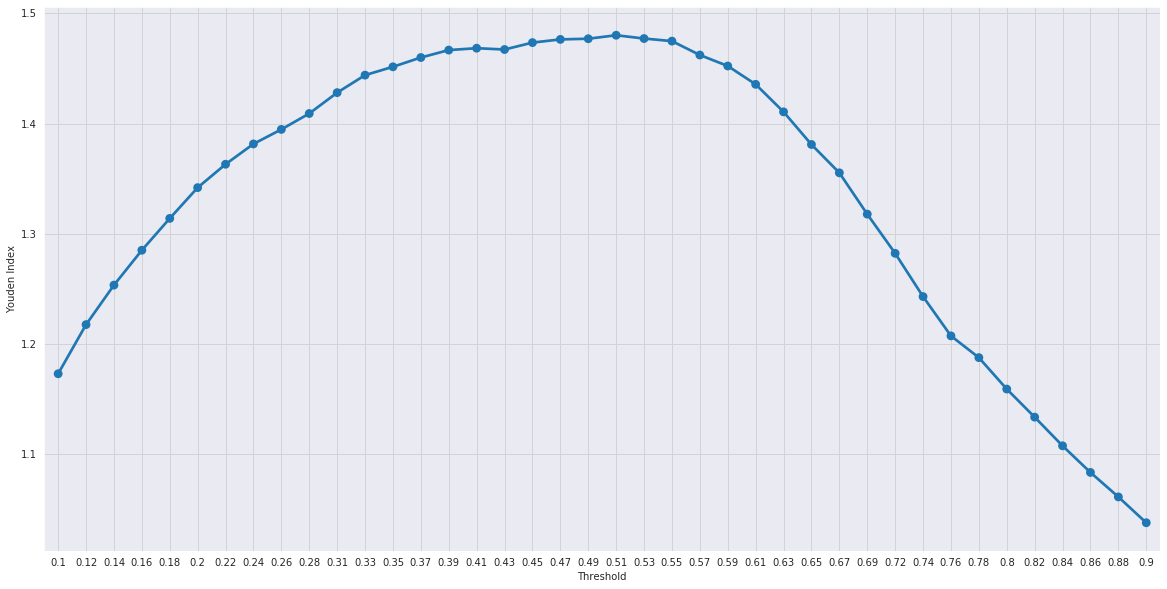

In [9]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

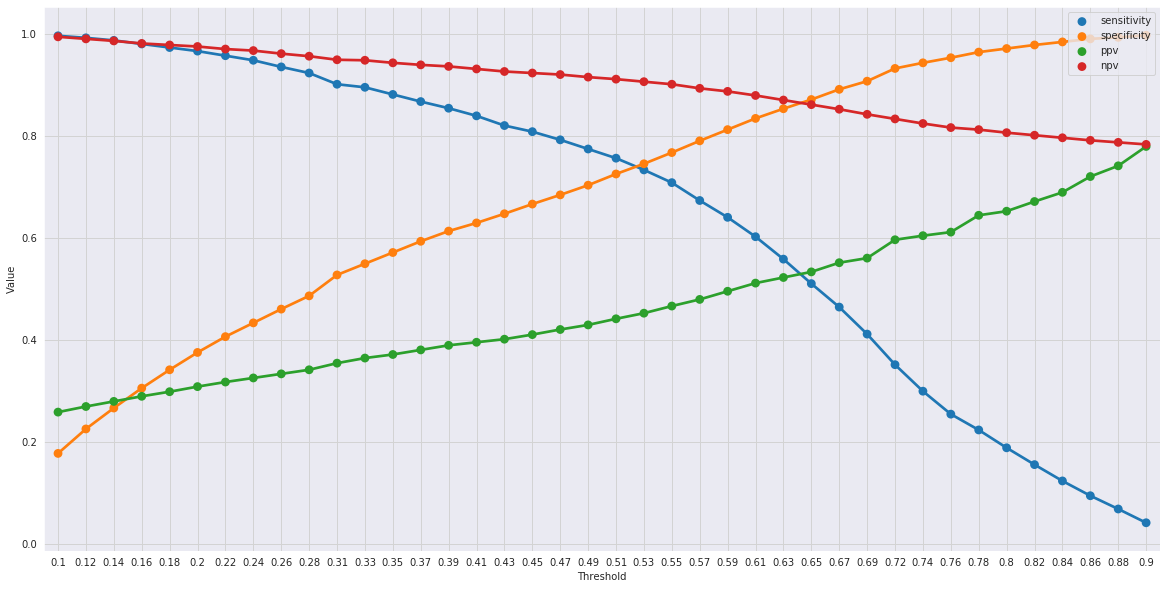

In [10]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.9, 40)

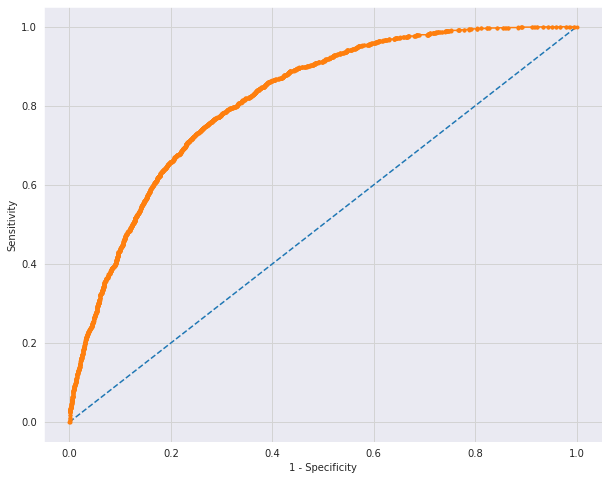

In [11]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [12]:
thresh = 0.45
y_pred = (prob > thresh).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.808
specificity,0.666
ppv,0.410
npv,0.923
f1,0.544
auroc,0.815


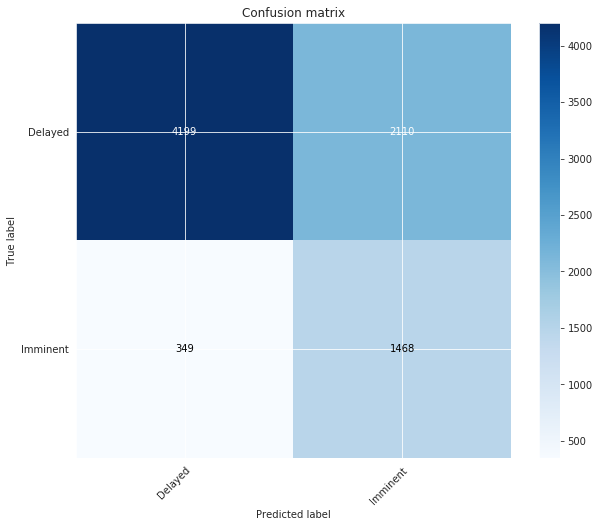

In [13]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

In [14]:
# scores = clf.coef_[0]/clf.coef_[0].sum()

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
# ax[0].imshow(neg_cloud)
# ax[0].axis('off')
# ax[0].set_title('Delayed ICU Admission')
# ax[1].imshow(pos_cloud)
# ax[1].axis('off')
# ax[1].set_title('Imminent ICU Admission')

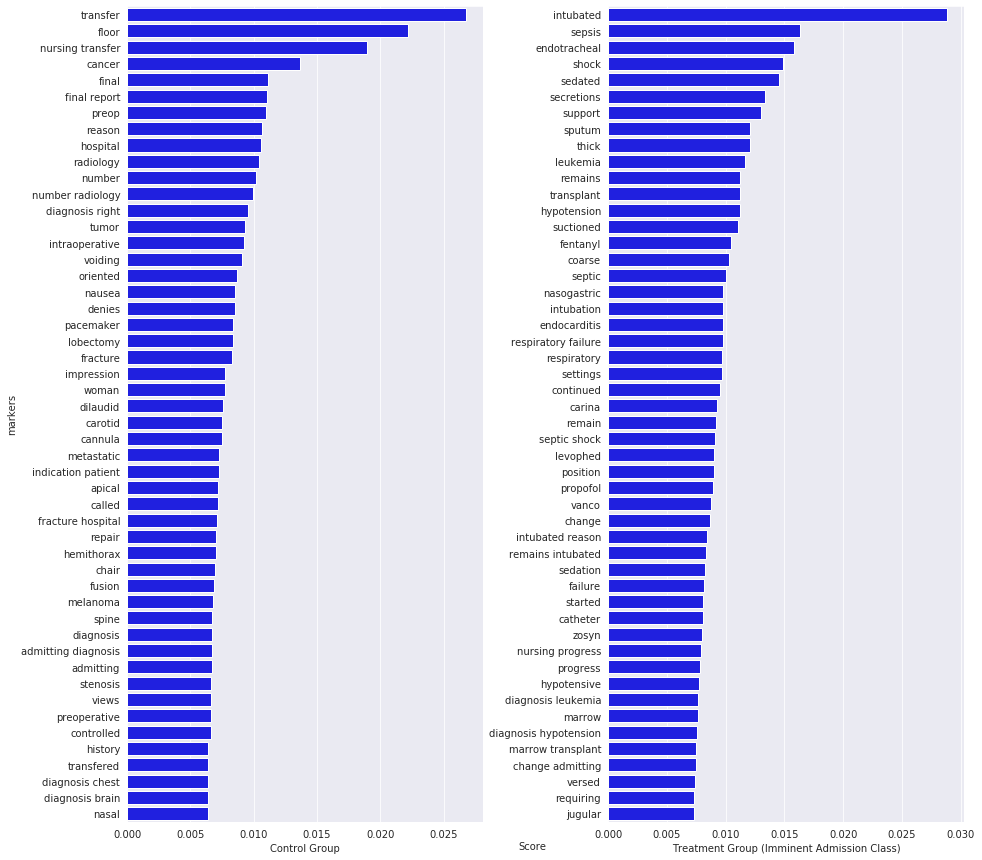

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
pos_df, neg_df = get_top_markers(vectorizer.get_feature_names(), clf.coef_[0], n_markers=50)
sns.barplot(x='score', y='markers', data=neg_df, color='b', ax=ax[0])
sns.barplot(x='score', y='markers', data=pos_df, color='b', ax=ax[1])
ax[0].set_xlabel('Control Group')
ax[1].set_xlabel('Treatment Group (Imminent Admission Class)')
ax[1].set_ylabel('')

plt.subplots_adjust(wspace = 0.35)
fig.text(0.5, 0.1, 'Score', ha='center')
fig.savefig(args.figdir/'ia_markers.tif', dpi=300)

### Prolonged ICU Stay

In [21]:
df = set_group_splits(ps_df.copy(), group_col='hadm_id', seed=seed)
vectorizer = TfidfVectorizer(sublinear_tf=True, ngram_range=(1,2), binary=True, max_features=60_000)

In [22]:
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

((60830, 4), (51844, 60000), (8986, 60000), (51844,), (8986,))

In [23]:
params = {
  'class_weight': 'balanced',
  'solver': 'liblinear',
  'multi_class': 'ovr',
  'dual': True,
}

In [24]:
clf = LogisticRegression(**params)

clf.fit(x_train, y_train)
prob = clf.predict_proba(x_test)[:, 1]

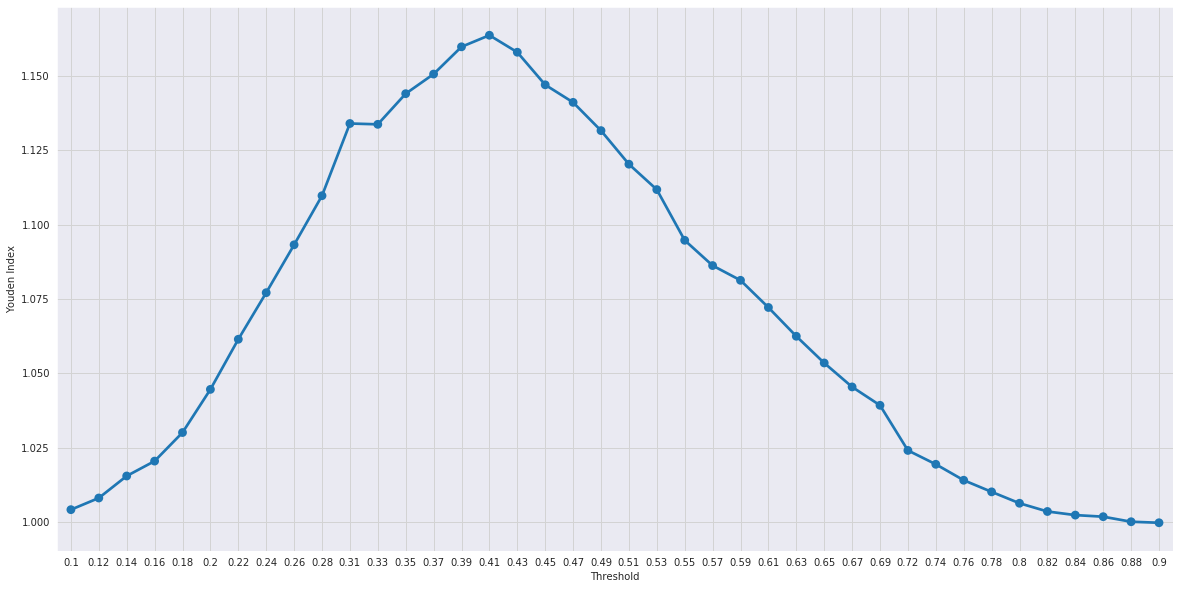

In [25]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_youden(ax, y_test, prob, 0.1, 0.9, 40)

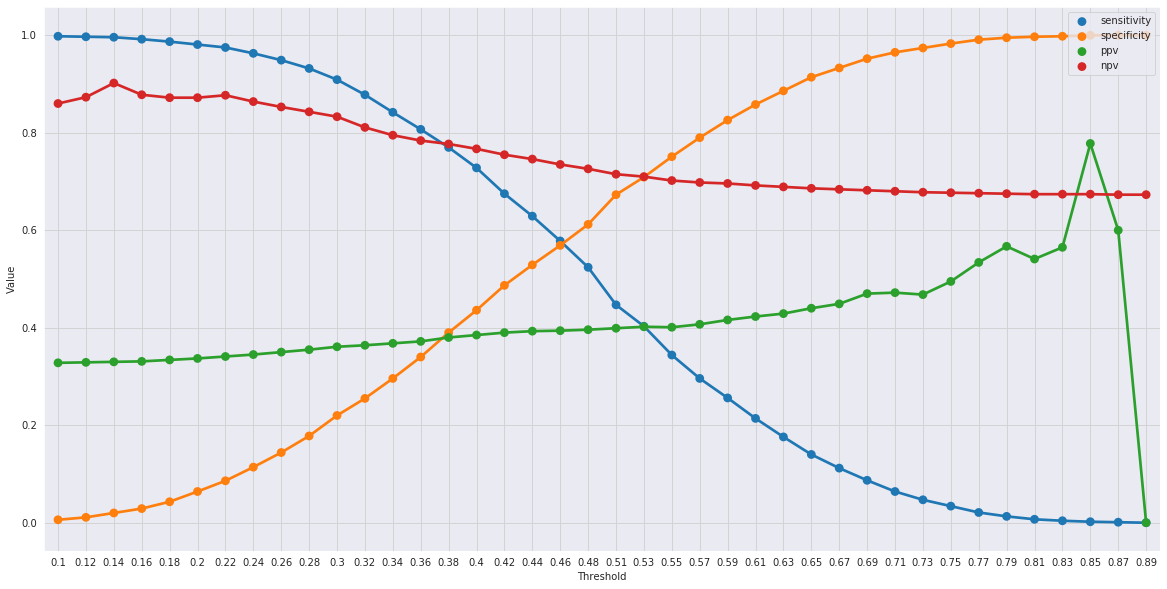

In [26]:
fig, ax = plt.subplots(figsize=(20, 10))
plot_thresh_range(ax, y_test, prob, 0.1, 0.89, 40)

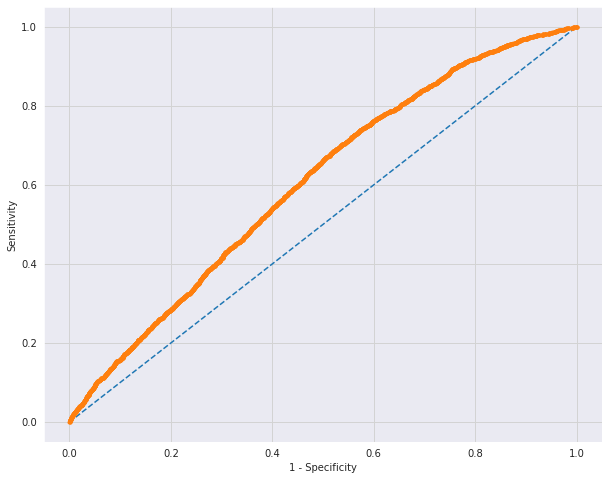

In [27]:
fig, ax = plt.subplots(figsize=(10,8))
plot_roc(ax, y_test, prob)

In [28]:
thresh = 0.41
y_pred = (prob > thresh).astype(np.int64)
cm = confusion_matrix(y_test, y_pred)
tn,fp,fn,tp = cm[0][0],cm[0][1],cm[1][0],cm[1][1]
prevalence = (fn+tp)/(tn+fp+fn+tp)
sensitivity = tp/(tp+fn)
specificity = tn/(tn+fp)
ppv = tp/(tp+fp)
npv = tn/(tn+fn)
f1 = (2*ppv*sensitivity)/(ppv+sensitivity)
auroc = roc_auc_score(y_test, prob)

d = {
  'sensitivity': np.round(sensitivity, 3),
  'specificity': np.round(specificity, 3),
  'ppv': np.round(ppv, 3),
  'npv': np.round(npv, 3),
  'f1': np.round(f1, 3),
  'auroc': np.round(auroc, 3),
  'prevalence': np.round(prevalence, 3),  
}

metrics = pd.DataFrame(d.values(), index=d.keys(), columns=['Value'])
metrics

,Value
sensitivity,0.702
specificity,0.462
ppv,0.388
npv,0.761
f1,0.500
auroc,0.606
prevalence,0.327


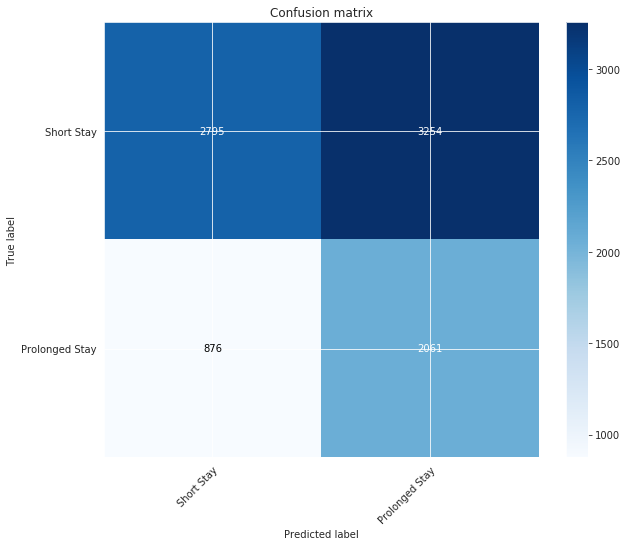

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, cm, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

In [30]:
# scores = clf.coef_[0]/clf.coef_[0].sum()

# fig, ax = plt.subplots(1, 2, figsize=(20, 10))
# neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
# ax[0].imshow(neg_cloud)
# ax[0].axis('off')
# ax[0].set_title('Short Stay')
# ax[1].imshow(pos_cloud)
# ax[1].axis('off')
# ax[1].set_title('Prolonged Stay')

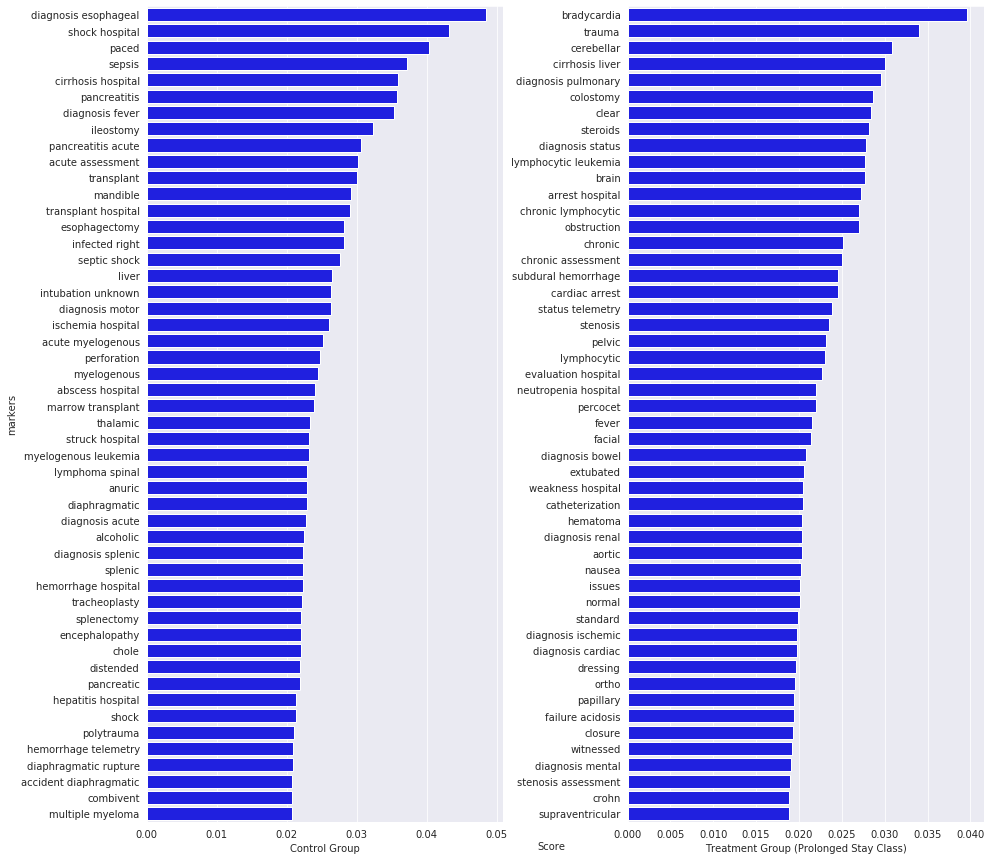

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(15, 15))
pos_df, neg_df = get_top_markers(vectorizer.get_feature_names(), clf.coef_[0], n_markers=50)
sns.barplot(x='score', y='markers', data=neg_df, color='b', ax=ax[0])
sns.barplot(x='score', y='markers', data=pos_df, color='b', ax=ax[1])
ax[0].set_xlabel('Control Group')
ax[1].set_xlabel('Treatment Group (Prolonged Stay Class)')
ax[1].set_ylabel('')

plt.subplots_adjust(wspace = 0.35)
fig.text(0.5, 0.1, 'Score', ha='center')
fig.savefig(args.figdir/'ps_markers.tif', dpi=300)

## Metrics

Taken from [here](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/):

1. Prevalence: `(fn + tp) / total`
2. Sensitivity: AKA recall, true positive rate `tp / (tp + fn)`
3. Specificity: AKA true negative rate `tn / (tn + fp)`
4. Positive Predictive Value (PPV): AKA precision `tp / (tp + fp)`
5. Negative Predictive Value (NPV): `tn / (tn + fn)`

### Imminent ICU Admission

In [ ]:
with open(args.workdir/f'imminent_adm_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'imminent_adm_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs, is_individual=False)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, bam.cm_avg, classes=['Delayed', 'Imminent'], normalize=False, title='Confusion matrix')

### Prolonged ICU Stay

In [ ]:
with open(args.workdir/f'prolonged_stay_preds.pkl', 'rb') as f:
  targs = pickle.load(f)
  preds = pickle.load(f)
  probs = pickle.load(f)

fnames = [f'prolonged_stay_seed_{seed}.pkl' for seed in range(args.start_seed, args.start_seed + 100)]
bam = BinaryAvgMetrics(targs, preds, probs)

In [ ]:
bam.get_avg_metrics(conf=0.95)

In [ ]:
get_best_model(bam, fnames)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_mean_roc(ax, bam.targs, bam.probs)

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
plot_confusion_matrix(ax, bam.cm_avg, classes=['Short Stay', 'Prolonged Stay'], normalize=False, title='Confusion matrix')

## Full Data

In [ ]:
seed = 643
ori_df = pd.read_csv(args.dataset_csv, usecols=args.cols, parse_dates=args.dates)
ori_df['relative_charttime'] = (ori_df['charttime'] - ori_df['intime'])

ia_df = ori_df.loc[(ori_df['imminent_adm_label'] != -1)][args.imminent_adm_cols + ['relative_charttime']].reset_index(drop=True)

ps_df = ori_df.loc[(ori_df['chartinterval'] != 0)][args.prolonged_stay_cols + ['relative_charttime']].reset_index(drop=True)

In [ ]:
interval_hours = 12
starting_day = -20
ending_day = -1

### Predict Imminent ICU Admission

In [ ]:
df = set_group_splits(ia_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['imminent_adm_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['imminent_adm_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
from args import ia_params
clf = LogisticRegression(**ia_params)

clf.fit(x_train, y_train)
df.loc[(df['split'] == 'test'), 'prob'] = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df.loc[(df['split'] == 'test')], args.ia_thresh, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.coef_[0]/clf.coef_[0].sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')

### Predict Prolonged ICU Stay

In [ ]:
df = set_group_splits(ps_df.copy(), pct=0.25, group_col='hadm_id', seed=seed)
df['prob'] = -1

vectorizer = TfidfVectorizer(min_df=args.min_freq, analyzer=str.split, sublinear_tf=True, ngram_range=(2,2))
x_train = vectorizer.fit_transform(df.loc[(df['split'] == 'train')]['processed_note'])
x_test = vectorizer.transform(df.loc[(df['split'] == 'test')]['processed_note'])
y_train = df.loc[(df['split'] == 'train')]['prolonged_stay_label'].to_numpy()
y_test = df.loc[(df['split'] == 'test')]['prolonged_stay_label'].to_numpy()
df.shape, x_train.shape, x_test.shape, y_train.shape, y_test.shape

In [ ]:
from args import ps_params
clf = LogisticRegression(**ps_params)

clf.fit(x_train, y_train)
df.loc[(df['split'] == 'test'), 'prob'] = clf.predict_proba(x_test)[:, 1]

In [ ]:
fig, ax = plt.subplots(figsize=(15, 8))
plot_prob(ax, df.loc[(df['split'] == 'test')], args.ia_thresh, starting_day, ending_day, interval_hours)

In [ ]:
scores = clf.coef_[0]/clf.coef_[0].sum()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 10))
neg_cloud, pos_cloud = get_wordcloud(vectorizer.get_feature_names(), scores, n_words=50)
ax[0].imshow(neg_cloud)
ax[0].axis('off')
ax[0].set_title('Negative Class')
ax[1].imshow(pos_cloud)
ax[1].axis('off')
ax[1].set_title('Positive Class')